### Movie Reviews Classification using Avg Word2Vec

In [64]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [65]:
#Importing Packages

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')


import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from collections import Counter
from tqdm import tqdm
import regex




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dinoking/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
#Loading Data
df = pd.read_csv('IMDB Dataset.csv')
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

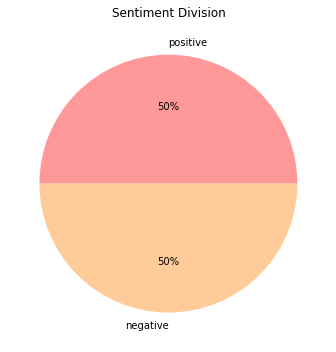

In [67]:
# EDA
plt.figure(figsize=(12,5))
colors = ['#ff9999','#ffcc99']
plt.pie(df.sentiment.value_counts(),colors=colors,labels=df.sentiment.unique(),autopct='%.f%%')
plt.title("Sentiment Division")
plt.tight_layout()
plt.show()

In [68]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [69]:
df.shape

(50000, 2)

In [70]:
#Data Cleaning
def cleantext(text):
    text = re.sub(r"<[^<]+?"," ", text)# HTML Tags Removal
    text = re.sub(r"[^A-Za-z0-9\s]"," ", text)#Special Characters Removal
    text = text.lower()
    return text

#Applying the Function to the data
df['review'] = df["review"].apply(cleantext)
df.head(5)

review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production   r    r   the f...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically there s a family where a little boy ...  negative
4  petter mattei s  love in the time of money  is...  positive

In [71]:
#StopWord Removal
list_stopwords = stopwords.words('english')

def remove_stopwords(text):
    tokens = [token.strip() for token in word_tokenize(text)]
    filtered_tokens = [token for token in tokens if token.lower() not in list_stopwords]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

df['review'] = df['review'].apply(remove_stopwords)
df.head(5)

review sentiment
0  one reviewers mentioned watching 1 oz episode ...  positive
1  wonderful little production r r filming techni...  positive
2  thought wonderful way spend time hot summer we...  positive
3  basically family little boy jake thinks zombie...  negative
4  petter mattei love time money visually stunnin...  positive

In [72]:
#Separate labels and reviews
labels = df.sentiment.values
reviews = df.review.values
reviews.shape, labels.shape

((50000,), (50000,))

In [73]:
#Tokenizer
review_word_token = [word_tokenize(text) for text in reviews]
review_word_token

[['one',
  'reviewers',
  'mentioned',
  'watching',
  '1',
  'oz',
  'episode',
  'hooked',
  'right',
  'exactly',
  'happened',
  'r',
  'r',
  'first',
  'thing',
  'struck',
  'oz',
  'brutality',
  'unflinching',
  'scenes',
  'violence',
  'set',
  'right',
  'word',
  'go',
  'trust',
  'show',
  'faint',
  'hearted',
  'timid',
  'show',
  'pulls',
  'punches',
  'regards',
  'drugs',
  'sex',
  'violence',
  'hardcore',
  'classic',
  'use',
  'word',
  'r',
  'r',
  'called',
  'oz',
  'nickname',
  'given',
  'oswald',
  'maximum',
  'security',
  'state',
  'penitentary',
  'focuses',
  'mainly',
  'emerald',
  'city',
  'experimental',
  'section',
  'prison',
  'cells',
  'glass',
  'fronts',
  'face',
  'inwards',
  'privacy',
  'high',
  'agenda',
  'em',
  'city',
  'home',
  'many',
  'aryans',
  'muslims',
  'gangstas',
  'latinos',
  'christians',
  'italians',
  'irish',
  'scuffles',
  'death',
  'stares',
  'dodgy',
  'dealings',
  'shady',
  'agreements',
  'ne

In [63]:
#Lemmatizer
review_lem = []
lem = WordNetLemmatizer()

for text in review_word_token:
    review_lem.append([lem.lemmatize(word) for word in text])
review_lem[0]

['one',
 'reviewer',
 'mentioned',
 'watching',
 '1',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'r',
 'r',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scene',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'r',
 'r',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focus',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 'aryan',
 'muslim',
 'gangsta',
 'latino',
 'christian',
 'italian',
 'irish',
 'scuffle',
 'death',
 'stare',
 'dodgy',
 'dealing',
 'shady',
 'agreement',
 'never',
 'far',
 'away',
 'r',
 'r',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'go',
 

In [77]:
#Check contextual stopwords
unlist =[]
for text in review_lem:
    unlist.extend(text)
Counter(unlist).most_common(10)

[('r', 202826),
 ('movie', 103282),
 ('film', 93462),
 ('one', 55450),
 ('like', 41132),
 ('time', 31469),
 ('good', 29868),
 ('character', 28361),
 ('story', 25276),
 ('even', 24872)]

In [78]:
#Remove it
cont_stop = ['br','1']
review_rem_cont=[]
for text in review_lem:
    review_rem_cont.append([word for word in text if word not in cont_stop])
review_rem_cont[0]    

['one',
 'reviewer',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'r',
 'r',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scene',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'r',
 'r',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focus',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 'aryan',
 'muslim',
 'gangsta',
 'latino',
 'christian',
 'italian',
 'irish',
 'scuffle',
 'death',
 'stare',
 'dodgy',
 'dealing',
 'shady',
 'agreement',
 'never',
 'far',
 'away',
 'r',
 'r',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'go',
 'show'

In [79]:
#Final Cleaned reviews
cleaned_reviews = [' '.join(text) for text in review_rem_cont]
cleaned_reviews[0]

'one reviewer mentioned watching oz episode hooked right exactly happened r r first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word r r called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away r r would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience w

In [80]:
# DATA PRE-PROCESSING

words = []
for sent in cleaned_reviews:
    sent_token = sent_tokenize(sent)
    for sent in sent_token:
        words.append(simple_preprocess(sent))
words

[['one',
  'reviewer',
  'mentioned',
  'watching',
  'oz',
  'episode',
  'hooked',
  'right',
  'exactly',
  'happened',
  'first',
  'thing',
  'struck',
  'oz',
  'brutality',
  'unflinching',
  'scene',
  'violence',
  'set',
  'right',
  'word',
  'go',
  'trust',
  'show',
  'faint',
  'hearted',
  'timid',
  'show',
  'pull',
  'punch',
  'regard',
  'drug',
  'sex',
  'violence',
  'hardcore',
  'classic',
  'use',
  'word',
  'called',
  'oz',
  'nickname',
  'given',
  'oswald',
  'maximum',
  'security',
  'state',
  'penitentary',
  'focus',
  'mainly',
  'emerald',
  'city',
  'experimental',
  'section',
  'prison',
  'cell',
  'glass',
  'front',
  'face',
  'inwards',
  'privacy',
  'high',
  'agenda',
  'em',
  'city',
  'home',
  'many',
  'aryan',
  'muslim',
  'gangsta',
  'latino',
  'christian',
  'italian',
  'irish',
  'scuffle',
  'death',
  'stare',
  'dodgy',
  'dealing',
  'shady',
  'agreement',
  'never',
  'far',
  'away',
  'would',
  'say',
  'main',
 

In [81]:
model = Word2Vec(words,vector_size=150,window=5,min_count=3)
model.corpus_count

50000

In [82]:
model.epochs

5

In [84]:
# AVGWORD2VEC
def avg_word2vec(doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv.index_to_key],axis=0)          


In [85]:
#Apply the Function to our data
X=[]
for i in tqdm(range(len(words))):
    X.append(avg_word2vec(words[i]))
Y=LabelEncoder().fit_transform(labels)

100%|██████████| 50000/50000 [04:41<00:00, 177.49it/s]


In [86]:
#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, shuffle=True, random_state=10)
np.array(X_train).shape, np.array(X_test).shape, y_train.shape, y_test.shape

((40000, 150), (10000, 150), (40000,), (10000,))

In [120]:
# APPLYING ML MODELS

In [121]:
#1. RANDOM FOREST
rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
pred_test = rf.predict(X_test)
acc1 = accuracy_score(y_test, pred_test)
print("The Accuracy of Random Forest Algorithm is :",acc1*100,"%")

print(classification_report(y_test, pred_test))


The Accuracy of Random Forest Algorithm is : 84.05 %
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5108
           1       0.82      0.86      0.84      4892

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [122]:
from sklearn.naive_bayes import BernoulliNB

In [123]:
# 2. NaiveBayes-BernoulliNB Classifier
BNB = BernoulliNB(fit_prior=False,alpha=0.5).fit(X_train, y_train)
pred_test = BNB.predict(X_test)
acc2 = accuracy_score(y_test, pred_test)
print("The Accuracy of NBBernoulli Algorithm is :",acc2*100,"%")

print(classification_report(y_test, pred_test))



The Accuracy of NBBernoulli Algorithm is : 74.02 %
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      5108
           1       0.76      0.68      0.72      4892

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [124]:
print(acc1)
print(acc2)

0.8405
0.7402


In [125]:
models = pd.DataFrame({
    'Model' : ['Random Forest Classifier', 'BernoulliNB'],
    'Score' : [acc1,acc2]
})

In [126]:
import plotly.express as px
px.bar(data_frame = models, x = 'Model', y = 'Score', color = 'Score', template = "plotly_dark", title = 'Models Comparison')